THIS IS THE MODIFIED NOTEBOOK FROM THE COURSE!

Angepasste/Hinzugefügte Stellen sind <span style="color:purple">lila</span> markiert.

In [1]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

In [2]:

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast#, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

In [88]:
# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
#from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'dislike', 'stop', 'rock', 'peace'] #added the other ones here

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

PATH = '../gesture_dataset_sample'

## helper function to load and parse annotations

In [89]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

<span style="color:purple">Hier wird auch mein JSON geladen:</span>

In [20]:
annot_emma = dict()

with open(f'annot-emma.json') as f:
    annot_emma = json.load(f)

In [10]:
# pretty-print first element
#000484ab-5fd0-49b8-9253-23a22b71d7b1
print(json.dumps(annotations['like']['0014182f-d756-42b3-896c-c52de76926bb'], indent=2))

{
  "bboxes": [
    [
      0.38056273,
      0.35650891,
      0.17322347,
      0.10461114
    ]
  ],
  "labels": [
    "like"
  ],
  "landmarks": [
    [
      [
        0.5497169170918876,
        0.4276043615779976
      ],
      [
        0.5218336293004483,
        0.40536586667786917
      ],
      [
        0.48288133220125257,
        0.3930262243722419
      ],
      [
        0.4501841862302019,
        0.37981099195030416
      ],
      [
        0.44251365410099686,
        0.36620499322043343
      ],
      [
        0.43138297470865106,
        0.406093902776592
      ],
      [
        0.4072660997339628,
        0.4073950234480344
      ],
      [
        0.42588200316326846,
        0.40612291879594015
      ],
      [
        0.4441470003072778,
        0.4049221293588555
      ],
      [
        0.4314493576491367,
        0.4212979654419442
      ],
      [
        0.42096276272263283,
        0.4180224457320293
      ],
      [
        0.43966095717106257,
      

## helper function to pre-process images (color channel conversion and resizing)

In [11]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [12]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

<span style="color:purple">Hier werden meine Bilder geladen:</span>

In [140]:
images_emma = [] # stores actual image data
labels_emma = [] # stores labels (as integer - because this is what our network needs)
#label_names_emma = [] # maps label ints to their actual categories so we can understand predictions later
picture_path = "pictures"

for filename in tqdm(os.listdir(picture_path)):
    # extract unique ID from file name
    UID = filename.split('.')[0]
    img = cv2.imread(f'{picture_path}/{filename}')
    
    # get annotation from the dict we loaded earlier
    try:
        annotation = annot_emma[UID]
    except Exception as e:
        print(e)
        continue
    
    # iterate over all hands annotated in the image
    for i, bbox in enumerate(annotation['bboxes']):
        # annotated bounding boxes are in the range from 0 to 1
        # therefore we have to scale them to the image size
        x1 = int(bbox[0] * img.shape[1])
        y1 = int(bbox[1] * img.shape[0])
        w = int(bbox[2] * img.shape[1])
        h = int(bbox[3] * img.shape[0])
        x2 = x1 + w
        y2 = y1 + h
        
        # crop image to the bounding box and apply pre-processing
        crop = img[y1:y2, x1:x2]
        preprocessed = preprocess_image(crop)
        
        # get the annotated hand's label
        # if we have not seen this label yet, add it to the list of labels
        label = annotation['labels'][i]
        if label not in label_names:
            label_names.append(label)
        print(label)
        
        label_index = label_names.index(label)
        
        images_emma.append(preprocessed)
        labels_emma.append(label_index)

  0%|          | 0/16 [00:00<?, ?it/s]

dislike
peace
dislike
peace
peace
dislike
''
stop
stop
stop
like
rock
like
rock
rock
like


## let's have a look at one of the images

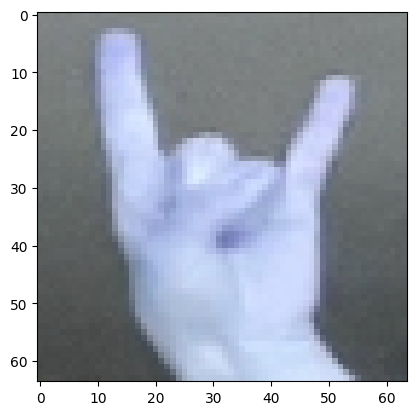

In [132]:
import time

#plt.imshow(random.sample(images, 1)[0])
plt.imshow(random.sample(images_emma, 1)[0])
# for i in range(0,15):
#     plt.imshow(images_emma[i])
#     print(labels_emma[i], label_names_emma[labels_emma[i]])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [133]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1301
326
1301
326


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [15]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(1301, 64, 64, 3) (326, 64, 64, 3) (1301, 6) (326, 6)


<span style="color:purple">Hier werden auch meine Daten umgeformt:</span>

In [134]:
X_test_emma = np.array(images_emma).astype('float32')
X_test_emma = X_test_emma / 255.

y_test_one_hot_emma = to_categorical(labels_emma)

test_label_emma = y_test_one_hot_emma

X_test_emma = X_test_emma.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

y_test_emma = labels_emma #added this here

print(X_test_emma.shape, test_label_emma.shape)

(15, 64, 64, 3) (15, 6)


In [18]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

## now, we can train the model using the fit() function
## this will take a while

In [50]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.2000 - loss: 1.8070 - val_accuracy: 0.2393 - val_loss: 1.7696 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.2165 - loss: 1.7796 - val_accuracy: 0.3926 - val_loss: 1.6505 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.3377 - loss: 1.6246 - val_accuracy: 0.4509 - val_loss: 1.3651 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.4901 - loss: 1.2435 - val_accuracy: 0.5583 - val_loss: 1.1387 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.6437 - loss: 0.8955 - val_accuracy: 0.7086 - val_loss: 0.7531 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7894 - loss: 0.6293 - val_accuracy: 0.8098 - val_loss: 0.5806 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7992 - loss: 

In [51]:
# let's have a look at our model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 64, 64, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,428 (1.13 MB)

 Trainable params: 99,142 (387.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 198,286 (774.56 KB)

## Plot accuracy and loss of the training process

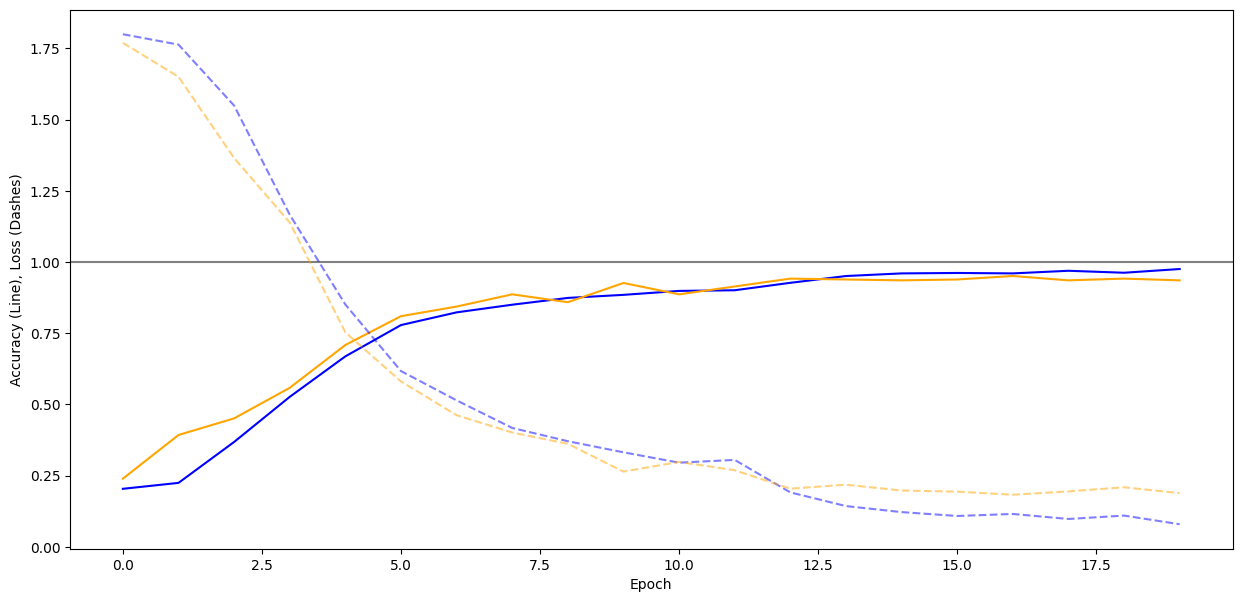

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [54]:
model.save('gesture_recognition.keras')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
before [[7.1540836e-04 2.1619569e-03 4.9448976e-05 9.5589769e-01 3.8522393e-02
  2.6530386e-03]
 [2.9364591e-13 1.2325591e-08 3.8788406e-13 4.2399909e-18 9.9999785e-01
  2.1071035e-06]
 [3.1480342e-02 4.3446063e-03 1.1232158e-03 7.1074642e-02 5.7156337e-03
  8.8626164e-01]
 ...
 [5.6336547e-04 2.0776977e-04 2.2527911e-06 9.9920797e-01 1.0895428e-06
  1.7491606e-05]
 [3.5932703e-06 9.9381340e-01 5.4837363e-03 9.6702564e-08 6.4665702e-04
  5.2552794e-05]
 [3.3200606e-05 9.9754071e-01 1.7530080e-03 2.4107526e-06 6.4441853e-04
  2.6299935e-05]]
(326, 6)
probabilities [3 4 5 1 0 4 3 1 5 0 5 2 1 5 5 5 2 2 1 2 1 1 4 0 4 0 0 0 5 0 3 1 1 3 1 1 0
 5 0 3 2 1 5 0 3 2 4 5 4 5 3 3 0 3 5 3 0 4 0 0 1 1 4 4 4 0 4 1 5 1 1 3 1 1
 0 5 1 5 5 2 5 3 0 5 2 1 3 0 5 1 4 2 2 2 2 2 5 1 3 4 5 2 0 1 3 0 4 1 5 5 1
 2 1 4 0 4 1 2 4 1 4 1 4 2 0 5 2 2 3 4 1 1 3 0 1 1 2 0 5 3 3 0 0 0 2 4 1 1
 5 1 0 2 3 3 2 3 2 4 1 5 4 5 1 2 1 0 1 5 0 2 1 4 2 3 4 2 1 5 2 4 5 2 4 2 4
 3 4 5 1 3 1 4 

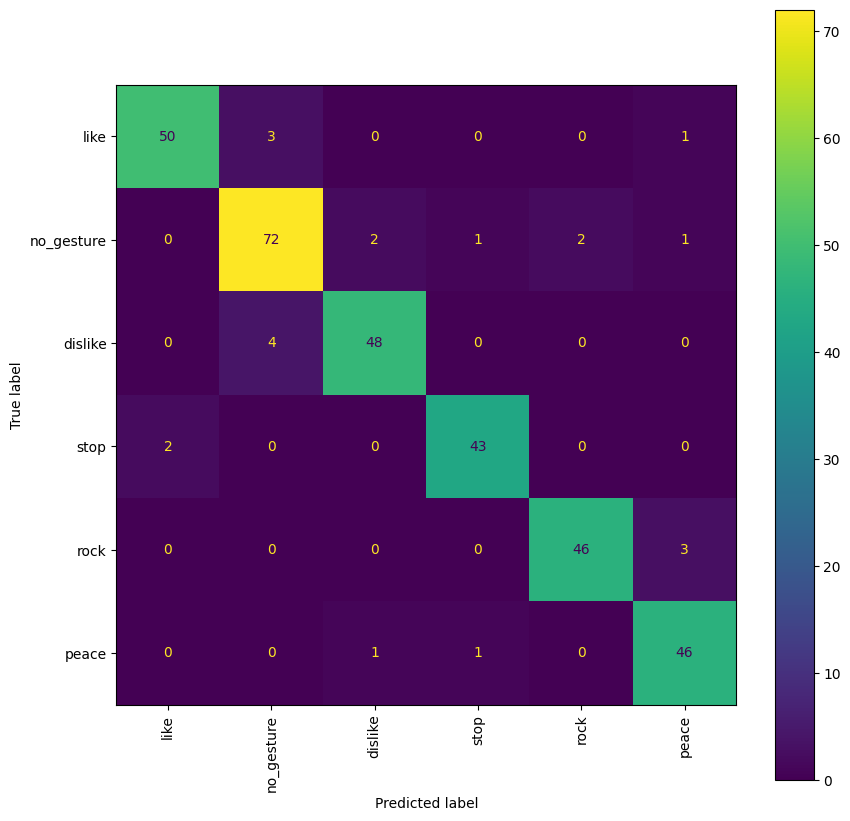

In [104]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

<span style="color:purple">Ein bisschen Testen:</span>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0]
like


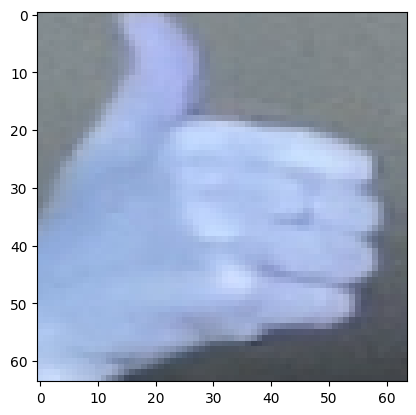

In [146]:
i = 14

plt.imshow(X_test_emma[i])
pred = model.predict(np.expand_dims(X_test_emma[i], axis=0))
pred = np.argmax(pred, axis=1)
print(pred)
print(label_names[pred[0]])

<span style="color:purple">Und nun meine Konfusionsmatrix:</span>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
before [[1.18629529e-07 5.85374830e-04 9.99412239e-01 1.52487214e-08
  7.04471290e-08 2.21774735e-06]
 [3.80876765e-04 1.15158374e-03 2.70813653e-05 4.57446475e-07
  9.27154266e-04 9.97512817e-01]
 [5.76369125e-14 9.81921911e-01 1.80778317e-02 8.75256681e-17
  1.95499538e-07 7.58372618e-12]
 [2.56208550e-05 8.38825713e-07 1.15708552e-07 1.23667157e-08
  3.20258248e-03 9.96770859e-01]
 [2.26264438e-05 5.41259169e-06 4.92301755e-09 5.12959857e-12
  1.32242703e-05 9.99958813e-01]
 [1.01168254e-04 2.68522233e-01 7.14222908e-01 3.95162306e-06
  6.80771796e-03 1.03420625e-02]
 [1.09893735e-05 1.72957778e-04 1.20810989e-12 9.99816060e-01
  4.18029389e-10 1.26364945e-08]
 [3.24820384e-08 8.42896100e-08 7.58743762e-13 9.99999881e-01
  4.50212506e-10 3.26543848e-10]
 [1.08441934e-01 4.44443710e-02 1.75483009e-07 8.47104549e-01
  9.32417549e-07 7.98203746e-06]
 [9.99040902e-01 9.22263076e-04 2.49806642e-09 3.65940105e-05
  1.31606193e-09 2.30396822e-07]
 [1.1

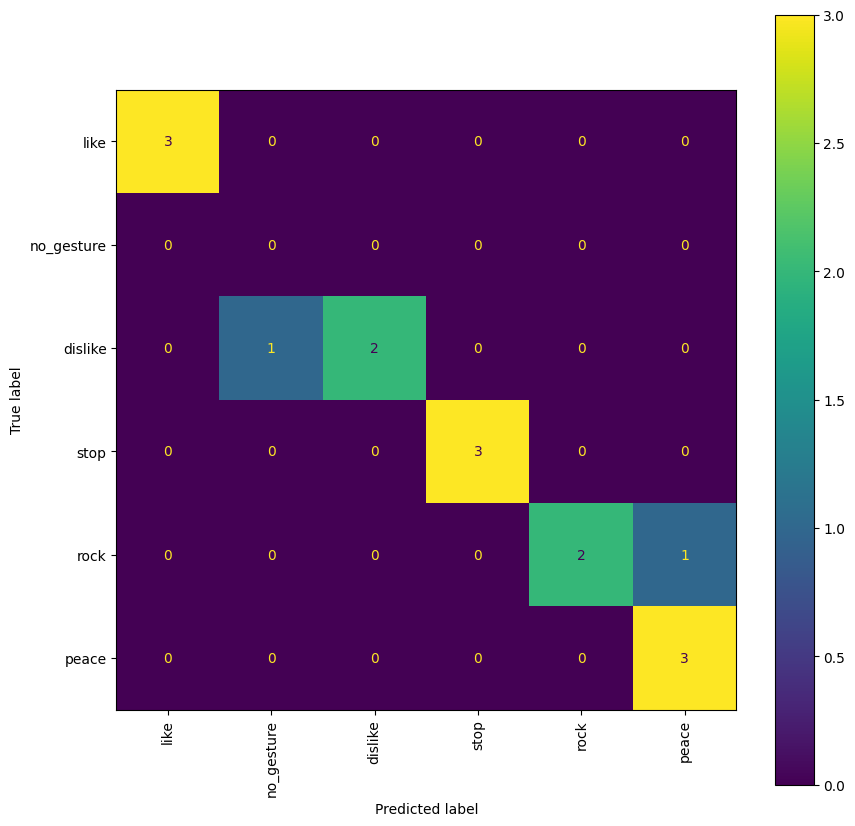

In [141]:
# let the model make predictions for our training data
y_predictions_emma = model.predict(X_test_emma)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions_emma)
print(y_predictions_emma.shape)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions_emma = np.argmax(y_predictions_emma, axis=1)

print('probabilities', y_predictions_emma)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_emma, y_predictions_emma)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')

plt.savefig('conf-matrix.png', format='png')
pass

## let's test our model in action

In [ ]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if COLOR_CHANNELS == 1:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
cap.release()
plt.imshow(frame)

## manual cropping for demonstration purposes - you can do better!

In [ ]:
cropped = frame[80:380, 240:410]
plt.imshow(cropped)

In [ ]:
resized = cv2.resize(cropped, SIZE)#[20:350, 200:420], SIZE)
plt.imshow(resized)
resized.shape

In [ ]:
reshaped = resized.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
reshaped.shape
prediction = model.predict(reshaped)

print(label_names[np.argmax(prediction)], np.max(prediction))

In [ ]:
filters, biases = model.layers[2].get_weights()
print(filters.shape)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        img = filters[:,:,:,i*8+j] * (1 / np.max(filters))
        axes[i][j].imshow(img)

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        #axes[i][j].imshow(filters[:,:,:,i*8+j] * 255, 'gray')
        kernel = filters[:,:,0,i*8+j]

        #print(kernel.shape)

        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        filtered = cv2.filter2D(gray, -1, kernel)

        axes[i][j].imshow(filtered, 'gray')

## Transfer Learning

let's use a pre-trained model (VGG16) for our prediction

note that VGG16 needs three color channels

In [ ]:
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU leaky_relu
layer_count = 2
num_neurons = 256

# load a VGG16 model trained on the imagenet dataset
# include_top=False -> do not include the output layer
# input_tensor -> tells the model about the dimensions of our images (VGG16 needs three color channels)
# pooling -> which type of pooling to use between convolutions; max or avg seem to be the best
VGG = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)), pooling='max')

# we want to use the VGG's original weights -> make those layers untrainable
for layer in VGG.layers:
    layer.trainable = False

# build a new model and add the VGG layers
model_vgg = Sequential()
model_vgg.add(VGG)

# append dense layers at the end
for i in range(layer_count - 1):
    model_vgg.add(Dense(num_neurons, activation=activation))
model_vgg.add(Dropout(0.2))

model_vgg.add(Dense(num_neurons, activation=activation))

# classifier
model_vgg.add(Dense(num_classes, activation='softmax'))

model_vgg.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history_vgg = model_vgg.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

In [ ]:
model_vgg.summary()

In [ ]:
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

In [ ]:
# let the model make predictions for our training data
y_predictions = model_vgg.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass